In [2]:
import scimap as sm
import pandas as pd
import sys
import os
import scanpy as sc
import seaborn as sns; sns.set(color_codes=True)
import anndata
adata = anndata.read_h5ad("/data/vasileiosionat2/IBEX_FINAL/Scimap/Adata/adata_ROIs.h5ad")
adata.obs

/gpfs/gsfs12/users/vasileiosionat2/conda/envs/scimap/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



,SampleID,Region,X_centroid,Y_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,...,spatial_kmeans_knn30_k10,spatial_kmeans_knn30_k12,spatial_kmeans_knn30_k11,spatial_kmeans_knn100_k8,spatial_kmeans_knn100_k10,spatial_kmeans_knn100_k12,niche_knn30k11,PatientID_Atlas,lvl4_spatial_cluster,niche_knn30k11_merged
0,HV196B,Epi,4063.439560,117.074176,364.0,22.370634,21.038466,0.339932,0.943005,0.659420,...,1,2,1,7,8,11,Spinous,CP-6,Ep.or.k,Oral Epi
1,HV196B,Epi,3906.382114,121.085366,246.0,20.441847,17.120427,0.546409,0.907749,0.615000,...,1,2,1,7,0,11,Spinous,CP-6,Ep.or.k,Oral Epi
2,HV196B,Epi,4046.433333,119.300000,150.0,16.610911,12.183316,0.679741,0.887574,0.721154,...,1,2,1,7,8,11,Spinous,CP-6,Ep.or.k,Oral Epi
3,HV196B,Epi,3925.083102,125.171745,722.0,36.032598,26.241478,0.685290,0.918575,0.705767,...,1,2,6,7,0,11,Crevicular,CP-6,Ep.or.k,T.A. Epi
4,HV196B,Epi,3950.053150,129.606299,508.0,27.802349,25.184052,0.423653,0.862479,0.627160,...,9,2,6,7,0,11,Crevicular,CP-6,Ep.or.k,T.A. Epi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370783,HV195A1,Epi,3129.127196,3308.111736,1423.0,51.882097,36.168967,0.716937,0.918065,0.748947,...,1,11,1,7,8,0,Spinous,HC-11,Ep.prol,Oral Epi
370784,HV195A1,Epi,2959.323333,3307.864444,900.0,37.111385,31.354542,0.534961,0.955414,0.802139,...,1,11,1,7,8,0,Spinous,HC-11,Ep.prol,Oral Epi
370785,HV195A1,Epi,2994.039424,3311.975739,1319.0,50.436389,35.218756,0.715824,0.913435,0.769096,...,1,11,1,7,8,0,Spinous,HC-11,Ep.prol,Oral Epi
370786,HV195A1,Epi,3047.255569,3311.067995,1706.0,64.079403,35.168771,0.835933,0.948305,0.880289,...,1,11,1,7,8,0,Spinous,HC-11,Ep.prol,Oral Epi


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

# Set a maximum distance threshold (in the same units as your coordinates)
max_distance = 3000  # Example threshold, adjust as needed

# Initialize an empty list to store results
results = []

# Get unique image IDs
image_ids = adata.obs['imageid'].unique()

for sample_name in image_ids:
    # Filter the data for the selected sample
    adata_sample = adata[adata.obs['imageid'] == sample_name]

    # Extract coordinates for the Crevicular niche
    crevicular_coords = adata_sample.obs.loc[
        adata_sample.obs['niche_knn30k11'] == 'Crevicular', 
        ['X_centroid', 'Y_centroid']
    ].to_numpy()

    # Check if there are enough Crevicular cells
    if crevicular_coords.shape[0] >= 200:
        # Extract coordinates for other niches
        niches = {
            'Lymphoid': adata_sample.obs.loc[adata_sample.obs['niche_knn30k11'] == 'Lymphoid', ['X_centroid', 'Y_centroid']].to_numpy(),
            'Plasma': adata_sample.obs.loc[adata_sample.obs['niche_knn30k11'] == 'Plasma', ['X_centroid', 'Y_centroid']].to_numpy(),
            'Neutrophil': adata_sample.obs.loc[adata_sample.obs['niche_knn30k11'] == 'Neutrophil (CT)', ['X_centroid', 'Y_centroid']].to_numpy()
        }

        # Track the unique cells and distances for each niche
        for target_niche, target_coords in niches.items():
            if target_coords.size > 0:
                distances = pairwise_distances(crevicular_coords, target_coords)
                
                # Find the indices of the target cells that are within the maximum threshold for any Crevicular cell
                valid_cells_indices = np.unique(np.where(distances <= max_distance)[1])
                
                # Filter the valid target coordinates
                valid_target_cells = target_coords[valid_cells_indices]
                
                # Count the number of unique target cells within the threshold
                num_unique_cells = len(valid_cells_indices)
                
                # Calculate the average distance for the valid target cells
                if num_unique_cells > 0:
                    valid_distances = distances[:, valid_cells_indices]
                    avg_distance = valid_distances[valid_distances <= max_distance].mean()
                else:
                    avg_distance = None
                    
                # Append the results to the list
                results.append({
                    'Sample': sample_name,
                    'Target Niche': target_niche,
                    'Average Distance': avg_distance,
                    'Unique Cells Count': num_unique_cells
                })
            else:
                results.append({
                    'Sample': sample_name,
                    'Target Niche': target_niche,
                    'Average Distance': None,
                    'Unique Cells Count': 0
                })
    else:
        results.append({
            'Sample': sample_name,
            'Target Niche': 'Crevicular',
            'Average Distance': None,
            'Unique Cells Count': 0
        })

# Convert results into a Pandas DataFrame
df_results = pd.DataFrame(results)

# Optionally, save the results to a CSV file
#df_results.to_csv('combined_distances_and_cells.csv', index=False)

# Display the results
print(df_results)


                       Sample Target Niche  Average Distance  \
0             HV196B_HV196B_0     Lymphoid       1511.735388   
1             HV196B_HV196B_0       Plasma       1667.442258   
2             HV196B_HV196B_0   Neutrophil       1542.791836   
3   HV214A2surg_HV214A2surg_0     Lymphoid       2159.110829   
4   HV214A2surg_HV214A2surg_0       Plasma       2226.018369   
5   HV214A2surg_HV214A2surg_0   Neutrophil        950.029256   
6             HV203B_HV203B_0     Lymphoid        678.032991   
7             HV203B_HV203B_0       Plasma       1940.151754   
8             HV203B_HV203B_0   Neutrophil        597.433000   
9             HV204B_HV204B_0   Crevicular               NaN   
10            HV189B_HV189B_0     Lymphoid        968.099035   
11            HV189B_HV189B_0       Plasma               NaN   
12            HV189B_HV189B_0   Neutrophil        544.684632   
13          HV220B2_HV220B2_0   Crevicular               NaN   
14  HV214A1surg_HV214A1surg_0   Crevicul

/gpfs/gsfs12/users/vasileiosionat2/conda/envs/scimap/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning:

All-NaN axis encountered

/gpfs/gsfs12/users/vasileiosionat2/conda/envs/scimap/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning:

All-NaN axis encountered

/gpfs/gsfs12/users/vasileiosionat2/conda/envs/scimap/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning:

All-NaN axis encountered

/gpfs/gsfs12/users/vasileiosionat2/conda/envs/scimap/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning:

All-NaN axis encountered



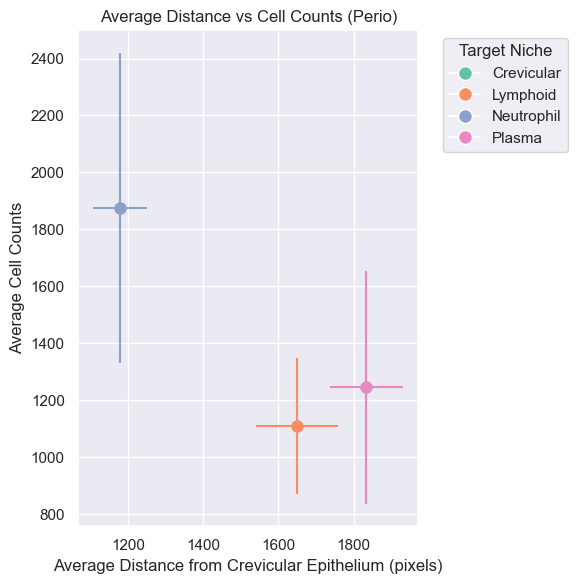

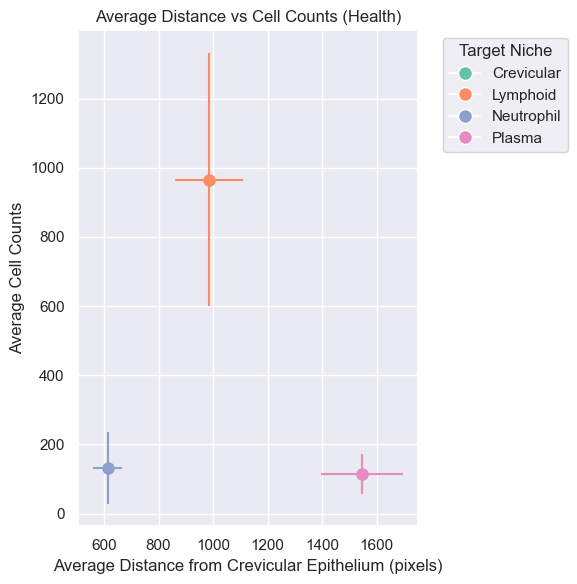

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Manually define the list of perio samples
perio_samples = [
    'HV137B1_HV137B1_0', 'HV137B2_HV137B2_0', 'HV140A1_HV140A1_0', 'HV140A2_HV140A2_0',
    'HV140B_HV140B_0', 'HV154B1_HV154B1_0', 'HV154B2_HV154B2_0', 'HV160D_HV160D_0',
    'HV196B_HV196B_0', 'HV204B_HV204B_0', 'HV214A1surg_HV214A1surg_0', 
    'HV214A2surg_HV214A2surg_0', 'HV214A_HV214A_0', 'HV219B1_HV219B1_0', 
    'HV219B2_HV219B2_0', 'HV219B3_HV219B3_0', 'TM327I_TM327I_0'
]

# Add a 'Sample Type' column based on the manual list of perio samples
df_results['Sample Type'] = df_results['Sample'].apply(lambda x: 'Perio' if x in perio_samples else 'Health')

# Calculate means, standard deviations, and sample counts for each group
summary_stats = df_results.groupby(['Sample Type', 'Target Niche'], as_index=False).agg(
    {
        'Unique Cells Count': ['mean', 'std', 'count'],
        'Average Distance': ['mean', 'std', 'count']
    }
)

# Flatten the column hierarchy
summary_stats.columns = [
    'Sample Type', 'Target Niche', 
    'Unique Cells Count Mean', 'Unique Cells Count Std', 'Unique Cells Count N',
    'Average Distance Mean', 'Average Distance Std', 'Average Distance N'
]

# Calculate standard errors
summary_stats['Unique Cells Count SE'] = summary_stats['Unique Cells Count Std'] / np.sqrt(summary_stats['Unique Cells Count N'])
summary_stats['Average Distance SE'] = summary_stats['Average Distance Std'] / np.sqrt(summary_stats['Average Distance N'])

# Define colors
palette = sns.color_palette('Set2', n_colors=summary_stats['Target Niche'].nunique())

# Function to create a plot for a given sample type
def plot_sample_type(sample_type, output_filename):
    filtered_stats = summary_stats[summary_stats['Sample Type'] == sample_type]

    plt.figure(figsize=(6, 6))

    for idx, (_, row) in enumerate(filtered_stats.iterrows()):
        plt.errorbar(
            x=row['Average Distance Mean'], 
            y=row['Unique Cells Count Mean'],
            xerr=row['Average Distance SE'],  
            yerr=row['Unique Cells Count SE'],  
            fmt='o',  
            color=palette[idx % len(palette)],
            label=f"{row['Target Niche']}",
            markersize=8
        )

    # Create legend for Target Niches
    niche_handles = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=palette[i], markersize=10,
                                 label=niche)
                     for i, niche in enumerate(filtered_stats['Target Niche'].unique())]

    plt.legend(handles=niche_handles, title='Target Niche', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'Average Distance vs Cell Counts ({sample_type})')
    plt.xlabel('Average Distance from Crevicular Epithelium (pixels)')
    plt.ylabel('Average Cell Counts')
    plt.grid(True)
    plt.tight_layout()

    # Save and show plot
    #plt.savefig(output_filename, format='pdf')
    plt.show()

# Generate and save the plots
plot_sample_type('Perio', "/data/vasileiosionat2/IBEX_FINAL/Scimap/Outputs/Figures_paper/Figure5/distances_IBEX_perio.pdf")
plot_sample_type('Health', "/data/vasileiosionat2/IBEX_FINAL/Scimap/Outputs/Figures_paper/Figure5/distances_IBEX_health.pdf")
